In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


In [2]:
#load in winpct data
winpct_data = pd.read_csv('cbb_winpct_model_data.csv')
#display first few rows
winpct_data.head()

,ADJOE,ADJDE,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,3P_O,3P_D,ADJ_T,WIN_PCT,POWER_CONF
0,123.3,94.9,52.6,48.1,15.4,18.2,40.7,30.0,32.3,30.4,32.7,36.2,71.7,0.825000,1
1,129.1,93.6,54.8,47.7,12.4,15.8,32.1,23.7,36.2,22.4,36.5,37.5,59.3,0.900000,1
2,114.4,90.4,53.9,47.7,14.0,19.5,25.5,24.9,30.7,30.0,35.2,33.2,65.9,0.825000,1
3,115.2,85.2,53.5,43.0,17.7,22.8,27.4,28.7,32.9,36.6,36.5,29.7,67.5,0.815789,1
4,117.8,86.3,56.6,41.1,16.2,17.1,30.0,26.2,39.0,26.9,38.2,29.0,71.5,0.948718,1


In [3]:
#Need to scale data for regression modeling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(winpct_data.drop('WIN_PCT', axis=1))
scaled_winpct_df = pd.DataFrame(scaled_features, columns=winpct_data.columns[:-1])
scaled_winpct_df['WIN_PCT'] = winpct_data['WIN_PCT']
scaled_winpct_df['POWER_CONF'] = winpct_data['POWER_CONF']
#display first few rows of scaled data
scaled_winpct_df.head()

,ADJOE,ADJDE,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,3P_O,3P_D,ADJ_T,WIN_PCT,POWER_CONF
0,2.663724,-1.326732,0.839076,-0.734002,-1.409568,-0.076181,2.709644,0.157552,-0.364310,-0.657735,-0.522121,0.805928,1.346045,0.825000,1
1,3.448692,-1.525061,1.552750,-0.874524,-2.800871,-1.114555,0.664338,-1.830136,0.356534,-1.935881,0.888487,1.350197,-2.794395,0.900000,1
2,1.459203,-2.013255,1.260792,-0.874524,-2.058843,0.486271,-0.905315,-1.451529,-0.660041,-0.721642,0.405910,-0.450075,-0.590612,0.825000,1
3,1.567475,-2.806571,1.131033,-2.525648,-0.342902,1.914035,-0.453445,-0.252606,-0.253411,0.332829,0.888487,-1.915413,-0.056362,0.815789,1
4,1.919357,-2.638755,2.136665,-3.193124,-1.038554,-0.552102,0.164903,-1.041371,0.874063,-1.216923,1.519548,-2.208481,1.279264,0.948718,1


In [4]:
# fit a linear regression model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
X = scaled_winpct_df.drop('WIN_PCT', axis=1)
y = scaled_winpct_df['WIN_PCT']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
linreg = LinearRegression()
linreg.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


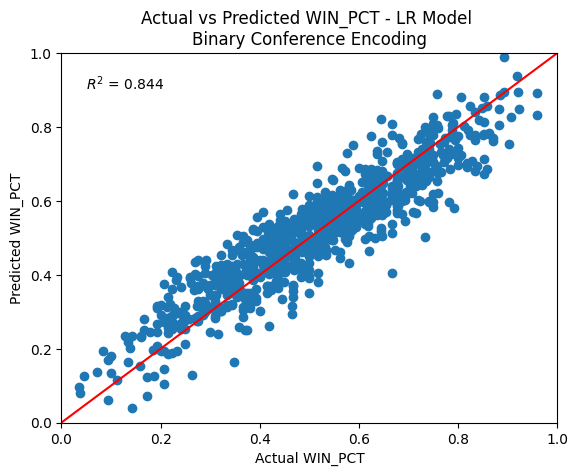

Mean Squared Error: 0.005137737792937519
R^2 Score: 0.8442795846035456


In [14]:
#plot predicted vs actual
y_pred = linreg.predict(X_test)
plt.scatter(y_test, y_pred)
plt.xlabel('Actual WIN_PCT')
plt.ylabel('Predicted WIN_PCT')
plt.title('Actual vs Predicted WIN_PCT - LR Model \nBinary Conference Encoding')
plt.plot([0, 1], [0, 1], color='red')
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.annotate(f'$R^2$ = {r2_score(y_test, y_pred):.3f}', xy=(0.05, 0.9), xycoords='axes fraction')
plt.show()

#evaluate model performance
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

Time for hyperparameter tuning!

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
params = {'fit_intercept': [True, False],
          'copy_X': [True, False],
          'n_jobs': [None, 1,5,10,15],}
linreg_grid = RandomizedSearchCV(estimator=linreg,
                                   param_distributions=params)
linreg_grid.fit(X_train, y_train)
print(f'Best Hyperparameters: {linreg_grid.best_params_}')

Best Hyperparameters: {'n_jobs': 1, 'fit_intercept': True, 'copy_X': True}


Tuned Mean Squared Error: 0.005137737792937519
Tuned R^2 Score: 0.8442795846035456


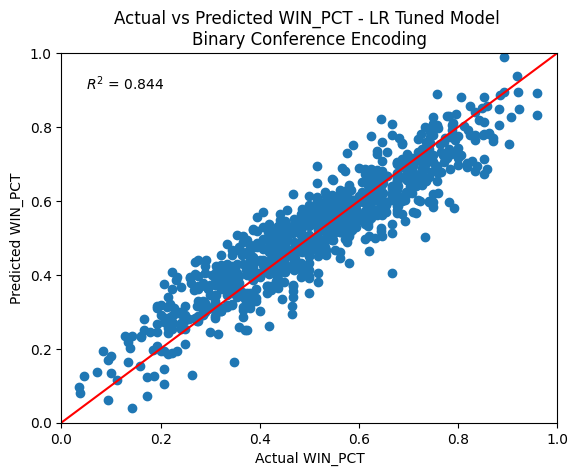

In [19]:
best_params = linreg_grid.best_params_
linreg_tuned = LinearRegression(**best_params)
linreg_tuned.fit(X_train, y_train)
y_pred_tuned = linreg_tuned.predict(X_test)
print(f'Tuned Mean Squared Error: {mean_squared_error(y_test, y_pred_tuned)}')
print(f'Tuned R^2 Score: {r2_score(y_test, y_pred_tuned)}')
plt.scatter(y_test, y_pred_tuned)
plt.xlabel('Actual WIN_PCT')
plt.ylabel('Predicted WIN_PCT')
plt.title('Actual vs Predicted WIN_PCT - LR Tuned Model \nBinary Conference Encoding')
plt.plot([0, 1], [0, 1], color='red')
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.annotate(f'$R^2$ = {r2_score(y_test, y_pred_tuned):.3f}', xy=(0.05, 0.9), xycoords='axes fraction')
plt.show()

In [6]:
#highest coefficients
coefficients = pd.DataFrame(linreg.coef_, X.columns, columns=['Coefficient'])
coefficients = coefficients.reindex(coefficients['Coefficient'].abs().sort_values(ascending=False).index)
print(coefficients)

            Coefficient
EFG_O          0.076640
EFG_D         -0.070168
TORD           0.062350
TOR           -0.049086
DRB           -0.041999
ORB            0.039746
POWER_CONF    -0.038118
FTRD          -0.026075
FTR            0.017047
ADJDE          0.015398
3P_D          -0.012213
ADJ_T          0.007378
ADJOE          0.005367
3P_O           0.002138


These results make logical sense pretty much across the board. Score more points = more wins. Get scored on more = Less wins. However, being in a power conference results in a lower win% which is suprising initially. However, this makes sense when you consider the results of who makes the tournament and who the best teams are (where the money is too)

Do that all again, but with one hot encoded data to see the most difficult/significant conferences

In [7]:
#load in winpct data with one-hot encoding for conference
cbb_winpct_ohe = pd.read_csv('cbb_winpct_ohe_model_data.csv')
cbb_winpct_ohe.head()

,ADJOE,ADJDE,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,...,CONF_P12,CONF_Pat,CONF_SB,CONF_SC,CONF_SEC,CONF_SWAC,CONF_Slnd,CONF_Sum,CONF_WAC,CONF_WCC
0,123.3,94.9,52.6,48.1,15.4,18.2,40.7,30.0,32.3,30.4,...,False,False,False,False,False,False,False,False,False,False
1,129.1,93.6,54.8,47.7,12.4,15.8,32.1,23.7,36.2,22.4,...,False,False,False,False,False,False,False,False,False,False
2,114.4,90.4,53.9,47.7,14.0,19.5,25.5,24.9,30.7,30.0,...,False,False,False,False,False,False,False,False,False,False
3,115.2,85.2,53.5,43.0,17.7,22.8,27.4,28.7,32.9,36.6,...,False,False,False,False,False,False,False,False,False,False
4,117.8,86.3,56.6,41.1,16.2,17.1,30.0,26.2,39.0,26.9,...,False,False,False,False,False,False,False,False,False,True


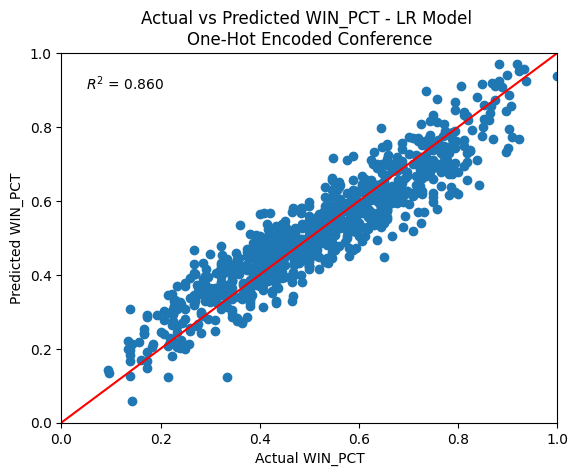

Mean Squared Error (One-Hot Encoded): 0.00446683201794567
R^2 Score (One-Hot Encoded): 0.859564238887312


In [15]:
# test linear regression with one-hot encoded conference data
X_ohe = cbb_winpct_ohe.drop('WIN_PCT', axis=1)
y_ohe = cbb_winpct_ohe['WIN_PCT']
X_train_ohe, X_test_ohe, y_train_ohe, y_test_ohe = train_test_split(X_ohe, y_ohe, test_size=0.2, random_state=16)
linreg_ohe = LinearRegression()
linreg_ohe.fit(X_train_ohe, y_train_ohe)
y_pred_ohe = linreg_ohe.predict(X_test_ohe)
# plot predicted vs actual for one-hot encoded model
plt.scatter(y_test_ohe, y_pred_ohe)
plt.xlabel('Actual WIN_PCT')
plt.ylabel('Predicted WIN_PCT')
plt.title('Actual vs Predicted WIN_PCT - LR Model \nOne-Hot Encoded Conference')
plt.plot([0, 1], [0, 1], color='red')
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.annotate(f'$R^2$ = {r2_score(y_test_ohe, y_pred_ohe):.3f}', xy=(0.05, 0.9), xycoords='axes fraction')
plt.show()
# evaluate one-hot encoded model performance
mse_ohe = mean_squared_error(y_test_ohe, y_pred_ohe)
r2_ohe = r2_score(y_test_ohe, y_pred_ohe)
print(f'Mean Squared Error (One-Hot Encoded): {mse_ohe}')
print(f'R^2 Score (One-Hot Encoded): {r2_ohe}')

More hyperparameter tuning!

In [20]:
lr_ohe_params = {'fit_intercept': [True, False],
          'copy_X': [True, False],
          'n_jobs': [None, 1,5,10,15],}
linreg_ohe_grid = RandomizedSearchCV(estimator=linreg_ohe, param_distributions=lr_ohe_params)
linreg_ohe_grid.fit(X_train_ohe, y_train_ohe)
print(f'Best Hyperparameters: {linreg_ohe_grid.best_params_}')

Best Hyperparameters: {'n_jobs': 10, 'fit_intercept': True, 'copy_X': True}


Tuned Mean Squared Error (One-Hot Encoded): 0.00446683201794567
Tuned R^2 Score (One-Hot Encoded): 0.859564238887312


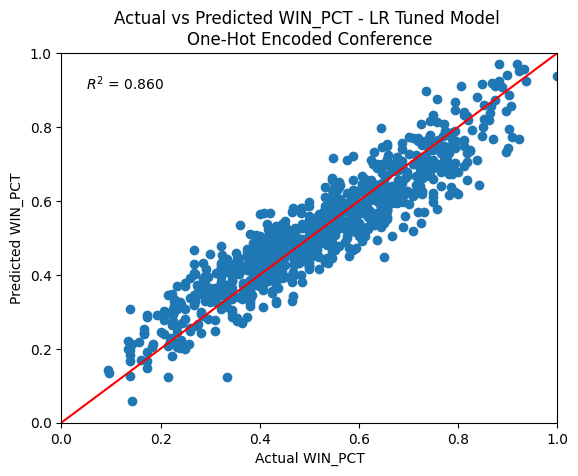

In [21]:
best_lrohe_params = linreg_ohe_grid.best_params_
linreg_ohe_tuned = LinearRegression(**best_lrohe_params)
linreg_ohe_tuned.fit(X_train_ohe, y_train_ohe)
y_pred_ohe_tuned = linreg_ohe_tuned.predict(X_test_ohe)
print(f'Tuned Mean Squared Error (One-Hot Encoded): {mean_squared_error(y_test_ohe, y_pred_ohe_tuned)}')
print(f'Tuned R^2 Score (One-Hot Encoded): {r2_score(y_test_ohe, y_pred_ohe_tuned)}')
plt.scatter(y_test_ohe, y_pred_ohe_tuned)
plt.xlabel('Actual WIN_PCT')
plt.ylabel('Predicted WIN_PCT')
plt.title('Actual vs Predicted WIN_PCT - LR Tuned Model \nOne-Hot Encoded Conference')
plt.plot([0, 1], [0, 1], color='red')
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.annotate(f'$R^2$ = {r2_score(y_test_ohe, y_pred_ohe_tuned):.3f}', xy=(0.05, 0.9), xycoords='axes fraction')
plt.show()

In [9]:
# Most important features from one-hot encoded model
coefficients_ohe = pd.DataFrame(linreg_ohe.coef_, X_ohe.columns, columns=['Coefficient'])
coefficients_ohe = coefficients_ohe.reindex(coefficients_ohe['Coefficient'].abs().sort_values(ascending=False).index)
print(coefficients_ohe)

           Coefficient
CONF_SWAC     0.135216
CONF_MEAC     0.131042
CONF_Slnd     0.127879
CONF_Ind      0.102542
CONF_ASun     0.102293
CONF_WAC      0.095319
CONF_NEC      0.094522
CONF_OVC      0.093892
CONF_BSky     0.089235
CONF_BSth     0.084744
CONF_SC       0.084480
CONF_Sum      0.082578
CONF_SB       0.076899
CONF_GWC      0.073188
CONF_AE       0.072876
CONF_BW       0.066658
CONF_MAC      0.061431
CONF_CAA      0.059890
CONF_Pat      0.057922
CONF_B10     -0.057352
CONF_CUSA     0.056885
CONF_Horz     0.056093
CONF_B12     -0.055355
CONF_ACC     -0.050972
CONF_MAAC     0.044310
CONF_BE      -0.042787
CONF_Ivy      0.039753
CONF_SEC     -0.038925
CONF_P12     -0.031314
CONF_MVC      0.021485
TORD          0.020247
EFG_D        -0.018499
TOR          -0.018472
EFG_O         0.016909
CONF_MWC      0.013956
DRB          -0.010516
CONF_WCC      0.010276
ORB           0.006226
ADJOE         0.006207
3P_D         -0.004267
FTRD         -0.004168
ADJDE        -0.004040
FTR        